<a href="https://colab.research.google.com/github/Sonlowami/HAI-DEF-Learn/blob/main/train_elixr_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Authentication

In [ ]:
!pip install -U tensorflow_text==2.17.0 >> /dev/null
!pip install -U tf-models-official==2.17 >> /dev/null

In [ ]:
from huggingface_hub import notebook_login, snapshot_download, hf_hub_download, HfFolder
import tensorflow as tf
import tensorflow_text as text
import tensorflow_models as tfm
import numpy as np
from typing import Iterable
import sklearn
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display, Image
print(tf.test.is_built_with_cuda())

True


In [ ]:
tf.__version__

'2.17.1'

In [ ]:
if HfFolder.get_token() is None:
  notebook_login()
else:
  print('Token already set')

Token already set


# **Load the models from HuggingFace**

In [ ]:
REPO_ID = 'google/cxr-foundation'
LOCAL_DIR = '/content/cxr-foundation/models'
repository_path = snapshot_download(repo_id=REPO_ID,
                                    allow_patterns=['elixr-c-v2-pooled/*', 'pax-elixr-b-text/*'],
                                    local_dir=LOCAL_DIR)
repository_path

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

(…)x-elixr-b-text/variables/variables.index:   0%|          | 0.00/5.91k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/46.0 [00:00<?, ?B/s]

(…)xr-c-v2-pooled/variables/variables.index:   0%|          | 0.00/28.8k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/6.89M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/9.17M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/724M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

'/content/cxr-foundation/models'

In [ ]:
elixr_c = tf.saved_model.load('/content/cxr-foundation/models/elixr-c-v2-pooled')
elixr_c_infer = elixr_c.signatures['serving_default']
elixr_c

# Download the dataset

In [ ]:
!pip install datasets >> /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset, concatenate_datasets
pneumo_ds = load_dataset("hf-vision/chest-xray-pneumonia")

README.md:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

train-00000-of-00007.parquet:   0%|          | 0.00/446M [00:00<?, ?B/s]

train-00001-of-00007.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

train-00002-of-00007.parquet:   0%|          | 0.00/68.9M [00:00<?, ?B/s]

train-00003-of-00007.parquet:   0%|          | 0.00/74.1M [00:00<?, ?B/s]

train-00004-of-00007.parquet:   0%|          | 0.00/59.9M [00:00<?, ?B/s]

train-00005-of-00007.parquet:   0%|          | 0.00/57.6M [00:00<?, ?B/s]

train-00006-of-00007.parquet:   0%|          | 0.00/57.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/78.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5216 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/624 [00:00<?, ? examples/s]

In [ ]:
train = pneumo_ds['train']
validation = pneumo_ds['validation']
test = pneumo_ds['test']

print(f'Training shape: {train.shape}')
print(f'Validation shape: {validation.shape}')
print(f'Test shape: {test.shape}')

Training shape: (5216, 2)
Validation shape: (16, 2)
Test shape: (624, 2)


In [ ]:
train_labels = pd.Series(train['label'])
validation_labels = pd.Series(validation['label'])
test_labels = pd.Series(test['label'])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
train_labels.value_counts(normalize=True).plot(kind='bar', ax=ax[0]).xaxis.set_ticklabels(['Pneumonia', 'Normal'])
validation_labels.value_counts(normalize=True).plot(kind='bar', ax=ax[1]).xaxis.set_ticklabels(['Pneumonia', 'Normal'])
test_labels.value_counts(normalize=True).plot(kind='bar', ax=ax[2]).xaxis.set_ticklabels(['Pneumonia', 'Normal'])


[Text(0, 0, 'Pneumonia'), Text(1, 0, 'Normal')]

**Balancing the Dataset**

There are two issues here:

1. The normal cases are 1/4 of the data. This means the model will be more likely to choose a normal over an abnormal image
2. The validation dataset is only 16 images long. This is a problem because normally, we would need the validation dataset to be a 10th of the training data available

**Solution:**
We are going to do the following:

- Recombine training and validation dataset into a single dataset
- Augment images to generate more data
- Random oversample the minority class
- Do the splitting again into train and validation dataset

In [ ]:
train_val = concatenate_datasets([train, validation])
train_val.shape[0] == train.shape[0]+ validation.shape[0]

True

In [ ]:
positive_class = train_val.filter(lambda example: example['label'] == 1)
negative_class = train_val.filter(lambda example: example['label'] == 0)
print(f'Positive class shape: {positive_class.shape}')
print(f'Negative class shape: {negative_class.shape}')

Filter:   0%|          | 0/5232 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5232 [00:00<?, ? examples/s]

Positive class shape: (3883, 2)
Negative class shape: (1349, 2)


In [ ]:
import datasets
def display_sample_images(dataset, num_samples=3):
  fig, ax = plt.subplots(1, num_samples, figsize=(15, 5))
  fig.suptitle('Sample Images')
  match (type(dataset)):
    case datasets.Dataset:
      for i in range(num_samples):
        sample = dataset[i]
        pil_image = sample['image'].convert("RGB")
        image_array = np.array(pil_image)
        ax[i].imshow(image_array)
        ax[i].axis('off')
        ax[i].set_title(sample['label'])
    #case tf.data.Dataset:
    #  for i, sample in enumerate(dataset.take(num_samples)):
    #    pil_image = tf.keras.preprocessing.image.array_to_img(sample['image'])
    #    image_array = np.array(pil_image.convert("RGB"))
    #    fig.add_trace(go.Image(z=image_array), row=1, col=i+1)
    # fig.update_layout(height=800, width=1200, title_text='Sample Images')
  fig.show()

print('Positive Class')
display_sample_images(positive_class)

Positive Class


In [ ]:
print('Negative Class')
display_sample_images(negative_class)

Negative Class


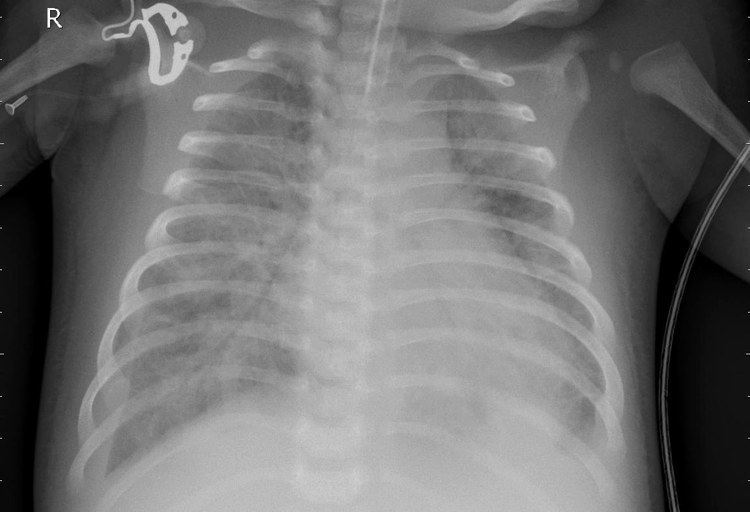

In [ ]:
def augment_image(image: tf.Tensor) -> tf.Tensor:
  image = tf.image.random_brightness(image, max_delta=0.3)
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
  image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
  return image

np_image = np.array(positive_class[0]['image'].convert('RGB'))
aug_image_tensor = augment_image(tf.convert_to_tensor(np_image))
aug_image = tf.keras.preprocessing.image.array_to_img(aug_image_tensor)
display(aug_image.resize((750, 512)))



In [ ]:
def augment_class(dataset, p, batch_size=32):
    '''
    Efficiently augment a dataset by processing in batches
    with a given probability p.
    '''
    def augment_batch(batch):
        augmented_batch = []
        for i in range(len(batch['image'])):
            sample = batch['image'][i]
            if np.random.rand() < p:
                # Convert to NumPy array and augment
                np_image = np.array(sample.convert('RGB'))
                aug_image_tensor = augment_image(tf.convert_to_tensor(np_image))
                # Convert back to PIL Image
                aug_image = tf.keras.preprocessing.image.array_to_img(aug_image_tensor)
                augmented_batch.append({'image': aug_image, 'label': batch['label'][i]})
        return augmented_batch

    # Process dataset in batches
    augmented_dataset = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]
        augmented_dataset.extend(augment_batch(batch))

    return datasets.Dataset.from_list(augmented_dataset)

In [ ]:
aug_dataset = augment_class(positive_class, 0.1)
print(type(aug_dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
display_sample_images(aug_dataset, 4)

In [ ]:
aug_neg_dataset = augment_class(negative_class, 0.3)
display_sample_images(aug_neg_dataset, 4)

In [ ]:
features = datasets.Features({
    'image': datasets.Image(),
    'label': datasets.Value(dtype='int64')
})

aug_dataset = aug_dataset.cast(features)
aug_neg_dataset = aug_neg_dataset.cast(features)
train_val = train_val.cast(features)

Casting the dataset:   0%|          | 0/369 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/394 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5232 [00:00<?, ? examples/s]

In [ ]:
dataset = concatenate_datasets([train_val, aug_dataset, aug_neg_dataset])
dataset.shape

(5995, 2)

In [ ]:
label_series = pd.Series(dataset['label'])
label_series.value_counts(normalize=True).plot(kind='bar')

<Axes: title={'center': '0'}>

In [ ]:
!pip install pypng >> /dev/null
import png
from PIL import Image
import io
def pil_to_tfexample(pil_image: Image) -> tf.train.Example:
    """Creates a tf.train.Example from a PIL Image."""
    # Convert the PIL Image to grayscale and ensure it's in the correct mode
    if pil_image.mode != 'L':  # 'L' mode is grayscale
        pil_image = pil_image.convert('L')

    # Convert the PIL Image directly to a NumPy array
    image_array = np.array(pil_image, dtype=np.uint16)

    # Determine the bit depth and scale the array accordingly
    bitdepth = 8 if image_array.max() <= 255 else 16
    if bitdepth == 16:
        image_array = (image_array / image_array.max() * 65535).astype(np.uint16)

    # Encode the NumPy array as PNG
    output = io.BytesIO()
    png.Writer(
        width=image_array.shape[1],
        height=image_array.shape[0],
        greyscale=True,
        bitdepth=bitdepth
    ).write(output, image_array.tolist())
    png_bytes = output.getvalue()

    # Create a tf.train.Example and assign the features
    example = tf.train.Example()
    features = example.features.feature
    features['image/encoded'].bytes_list.value.append(png_bytes)
    features['image/format'].bytes_list.value.append(b'png')

    return example


In [ ]:
def generate_embeddings(img: Image):
  serialized_img = pil_to_tfexample(img).SerializeToString()

  if 'elixrc_model' not in locals():
    elixrc_model = tf.saved_model.load('/content/cxr-foundation/models/elixr-c-v2-pooled')
    elixrc_infer = elixrc_model.signatures['serving_default']

  output = elixrc_infer(input_example=tf.constant([serialized_img]))
  elixrc_embedding = output['feature_maps_0'].numpy()

  if 'qformer_model' not in locals():
    qformer_model = tf.saved_model.load('/content/cxr-foundation/models/pax-elixr-b-text')
    qformer_infer = qformer_model.signatures['serving_default']

  qformer_input = {
      'image_feature': elixrc_embedding.tolist(),
      'ids': np.zeros((1, 1, 128), dtype=np.int32).tolist(),
      'paddings': np.zeros((1, 1, 128), dtype=np.float64).tolist()
  }
  q_former_output = qformer_infer(**qformer_input)
  elixrb_embeddings = q_former_output['all_contrastive_img_emb']

  return { 'embeddings': elixrb_embeddings }


In [ ]:
train, val = dataset.train_test_split(test_size=0.1, shuffle=True, seed=42).values()
print(f'Training shape: {train.shape}')
print(f'Validation shape: {val.shape}')

Training shape: (5395, 2)
Validation shape: (600, 2)


In [ ]:
#train.save_to_disk('/content/cxr-foundation/data/train')
#val.save_to_disk('/content/cxr-foundation/data/val')

In [ ]:
#from datasets import load_from_disk
#train = load_from_disk('/content/cxr-foundation/data/train')
#val = load_from_disk('/content/cxr-foundation/data/val')

In [ ]:
batch_size = 32
batch_1 = train.shuffle(seed=42).select(range(batch_size))
batch_1.shape

(32, 2)

In [ ]:
def load_n_batch_embeddings(batch_size: int, ds: datasets.Dataset, start_index: int, n_batches: int):
  embs = []
  for i in range(n_batches):
    batch = ds.select(range(start_index, start_index + batch_size))
    embeddings_batch = batch.map(lambda sample: generate_embeddings(sample['image']))
    embs.extend([x['embeddings'] for x in embeddings_batch])
    start_index += batch_size
  return embs

In [ ]:
train_embeddings = np.concatenate(list(load_n_batch_embeddings(batch_size, train, 512 + 256, 8)))
train_embeddings.shape

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

(256, 32, 128)

In [ ]:
train_embeddings.shape

(256, 32, 128)

In [ ]:
with open('/content/cxr-foundation/train_embeddings_batch_24_to_32  .npy', 'wb') as f:
  np.save(f, train_embeddings)

In [ ]:
!mkdir -p /content/data/train /content/data/val

In [ ]:
val_embeddings = np.load('/content/data/val/val_embeddings_batch_0_to_2.npy')
val_embeddings.shape

(96, 32, 128)

In [ ]:
train_embeddings = [np.load(f'/content/data/train/train{x}.npy') for x in range(1, 8)]
train_embeddings = np.concatenate(train_embeddings)
train_embeddings.shape

(1024, 32, 128)

In [ ]:
train_labels = np.array(train['label'][:train_embeddings.shape[0]])
val_labels = np.array(val['label'][:val_embeddings.shape[0]])
print(train_labels.shape)
print(val_labels.shape)

(1024,)
(96,)


In [ ]:
df_train = pd.DataFrame({'embedding': list(train_embeddings), 'label': train_labels})
df_val = pd.DataFrame({'embedding': list(val_embeddings), 'label': val_labels})

In [ ]:
# Function reused. Copied from https://colab.research.google.com/github/google-health/cxr-foundation/blob/master/notebooks/train_data_efficient_classifier.ipynb
def create_tf_dataset_from_embeddings(
    embeddings: Iterable[np.ndarray],
    labels: Iterable[int]
) -> tf.data.Dataset:
    """Create a tf.data.Dataset from embeddings, image IDs, and labels."""
    embeddings = list(embeddings)
    labels = list(labels)

    assert len(embeddings) == len(labels), \
        "Lengths of embeddings, and labels must be equal"

    embeddings = [np.asarray(e.flatten(), dtype=np.float32) for e in embeddings]
    ds_embeddings = tf.data.Dataset.from_tensor_slices(embeddings)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((ds_embeddings, ds_labels))

    return dataset

In [ ]:
# Function reused. Copied from https://colab.research.google.com/github/google-health/cxr-foundation/blob/master/notebooks/train_data_efficient_classifier.ipynb
def create_model(heads,
                 token_num,
                 embeddings_size,
                 learning_rate=0.1,
                 end_lr_factor=1.0,
                 dropout=0.0,
                 decay_steps=1000,
                 loss_weights=None,
                 hidden_layer_sizes=[512, 256],
                 weight_decay=0.0,
                 seed=None) -> tf.keras.Model:
  """
  Creates linear probe or multilayer perceptron using LARS + cosine decay.
  """
  inputs = tf.keras.Input(shape=(token_num * embeddings_size,))
  inputs_reshape = tf.keras.layers.Reshape((token_num, embeddings_size))(inputs)
  inputs_pooled = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(inputs_reshape)
  hidden = inputs_pooled
  for size in hidden_layer_sizes:
    hidden = tf.keras.layers.Dense(
        size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(
            hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
  output = tf.keras.layers.Dense(
      units=len(heads),
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(
          hidden)

  model = tf.keras.Model(inputs, output)
  learning_rate_fn = tf.keras.optimizers.schedules.CosineDecay(
      tf.cast(learning_rate, tf.float32),
      tf.cast(decay_steps, tf.float32),
      alpha=tf.cast(end_lr_factor, tf.float32))
  model.compile(
      optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate_fn),
      loss='binary_crossentropy',
      loss_weights=loss_weights or dict([(head, 1.) for head in heads]),
      weighted_metrics=[
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.AUC(curve='PR', name='auc_pr')])
  return model

In [ ]:
import os
TOKEN_NUM = train_embeddings.shape[1]
EMBEDDINGS_SIZE = train_embeddings.shape[2]
training_dataset = create_tf_dataset_from_embeddings(train_embeddings, train_labels)
validation_dataset = create_tf_dataset_from_embeddings(val_embeddings, val_labels)

model = create_model(heads=['Pneumonia'],
                     token_num=TOKEN_NUM,
                     embeddings_size=EMBEDDINGS_SIZE)

checkpoint_path = '/content/cxr-foundation/models/checkpoint/'
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{checkpoint_path}/model.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


model.fit(
    x=training_dataset.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_dataset.batch(32).cache(),
    epochs=200,
    callbacks=[checkpoint_callback]
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - auc_35: 0.4556 - auc_pr: 0.6682 - false_negatives_35: 308.3333 - false_positives_35: 141.6667 - loss: 2.4161 - true_negatives_35: 113.0000 - true_positives_35: 290.3333 - val_auc_35: 0.5000 - val_auc_pr: 0.6875 - val_false_negatives_35: 66.0000 - val_false_positives_35: 0.0000e+00 - val_loss: 22.2098 - val_true_negatives_35: 30.0000 - val_true_positives_35: 0.0000e+00
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - auc_35: 0.4335 - auc_pr: 0.6615 - false_negatives_35: 324.3333 - false_positives_35: 149.0000 - loss: 4.0852 - true_negatives_35: 105.6667 - true_positives_35: 274.3333 - val_auc_35: 0.4551 - val_auc_pr: 0.6575 - val_false_negatives_35: 35.0000 - val_false_positives_35: 14.0000 - val_loss: 13.1554 - val_true_negatives_35: 16.0000 - val_true_positives_35: 31.0000
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc_35: 0.5625 - auc_pr: 0.7419 - false_negatives_35: 135.0000 - false_positives_35: 178.6667 - loss: 2.0559 -

In [ ]:
rows = []
for embedding, label in training_dataset.batch(1):
  row = {'prediction': model(embedding).numpy().flatten()[0], 'label': label.numpy()[0]}
  rows.append(row)
df_eval = pd.DataFrame(rows)
df_eval.head()


,prediction,label
0,1.000000,1
1,0.997495,0
2,0.995899,1
3,0.999889,1
4,0.894977,0


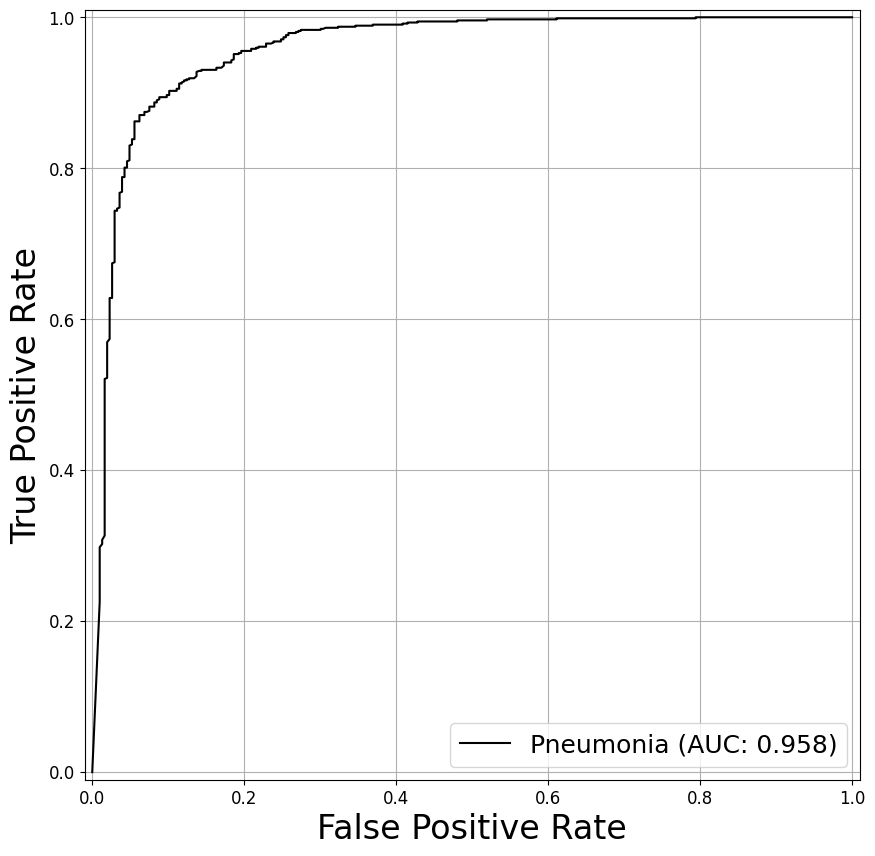

In [ ]:
def plot_curve(x, y, auc, x_label=None, y_label=None, label=None):
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, y, label=f'{label} (AUC: %.3f)' % auc, color='black')
  plt.legend(loc='lower right', fontsize=18)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  if x_label:
    plt.xlabel(x_label, fontsize=24)
  if y_label:
    plt.ylabel(y_label, fontsize=24)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(visible=True)

%matplotlib inline
labels = df_eval['label'].values
predictions = df_eval['prediction'].values
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
    labels,
    predictions,
    drop_intermediate=False)
auc = sklearn.metrics.roc_auc_score(labels, predictions)
plot_curve(false_positive_rate, true_positive_rate, auc, x_label='False Positive Rate', y_label='True Positive Rate', label='Pneumonia')

# References:

1. Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2